## Scoring oncogene induced senescence in mouse hepatocytes  

In this example we will use senePy to score single-cells which are undergoing cellular senescence


In [1]:
#installation - recommened installing in a conda or virtual environment with python >=3.7
#%pip install senepy

In [2]:
#load modules
import senepy as sp
import scanpy as sc

### Dataset: Chan et al 2024 
KRAS oncogene induced cellular senescence in mouse hepatocytes  
10.1038/s41586-024-07797-z  

**Samples:** mV: control, D12: 12 days after KRAS induction via tail-vein injection  

Toy data are subset to only include 500 total cells from mV and D12

In [3]:
adata = sc.read_h5ad('toy_data/TOY_DATA_Chan_et_al_2024.h5ad')

In [4]:
adata

AnnData object with n_obs × n_vars = 500 × 15766
    obs: 'Sample'
    var: 'n_cells'

In [5]:
hubs = sp.load_hubs(species = 'Mouse') #supports mouse and human

### Deciding which signature to use  

These are mouse hepatocytes, so we want to focus on liver/hepatocytes

In [6]:
hubs.metadata.tissue.unique()

array(['Bladder', 'Brain', 'Diaphragm', 'Fat', 'HSC', 'Heart_and_Aorta',
       'Kidney', 'Large_Intestine', 'Limb_Muscle', 'Liver', 'Lung',
       'Lymphoid', 'Myeloid', 'Pancreas', 'Thymus', 'Tongue', 'Trachea'],
      dtype=object)

In [7]:
#if we want to see the metadata for every senePy signature
hubs.metadata[hubs.metadata.tissue == 'Liver']

,tissue,cell,hub_num,size,n_sen,hyp
40,Liver,Kupffer cell,0,638,14,2.268194e-03
41,Liver,Kupffer cell,1,3305,17,9.983103e-01
42,Liver,endothelial cell of hepatic sinusoid,0,205,12,4.280991e-07
43,Liver,hepatocyte,0,1600,14,6.086587e-01
44,Liver,hepatocyte,1,143,7,3.511115e-04


There are **two** hepatocyte signatures because there are two distinct modes of cellular senescence within aging hepatocytes  

We will pick both and we will use the senePY **universal** signature

**Making the unviversal signature**  

We pass hubs.metadata, which contains every senePy signature  

We specify **calculate_thresh = True** to find the genes that are statistically overrepresented and set the FDR p-value threshold to 0.01

In [8]:
merge_results = hubs.merge_hubs(hubs.metadata, new_name = 'Universal',
                calculate_thresh = True, p_thres = 0.01)

merge_results.head()

A gene will occur 5 times at 0.44% chance
Threfore 5 is the calculated_threshold


,Gene,Count,p value,q value
0,Hba-a1,27,0.0,0.0
1,Hbb-b1,20,0.0,0.0
2,Gm11428,19,0.0,0.0
3,Vsig4,18,0.0,0.0
4,Saa3,18,0.0,0.0


In [9]:
#hubs.hubs now contains a 'Universal' signature
len(hubs.hubs['Universal'])

617

### Scoring cells

Datasets are often processed with differing references. This means genes may be annotated with slightly different names. We provide a function in senePy that translates genes between datasets so that there is better overlap.  

In this case we have 4882 global senePy genes that are not found in the adata object. Don't worry if there are still some not translated because many of these may be because the genes are not expressed in your data. But we did map 1559 genes just based on naming differences.  

Since these are heavily subset toy data, there will be less overlap

In [10]:
translator = sp.translator(hub = hubs.hubs, data = adata)

4882 of 20163 genes not initially present
1559 of 4882 translated
3323 still not present


In [11]:
#the hub key is based on the values in the metadata, we will pass this directly to sp.score_hub
hubs.hubs[('Liver', 'hepatocyte', 0)][0:10]

[('Ripply1', 369),
 ('Cdc20', 213),
 ('Olfr1029', 251),
 ('Akt3', 30),
 ('Epb4.9', 55),
 ('Arhgef37', 930),
 ('Tbc1d2', 215),
 ('Vmn2r29', 671),
 ('Chaf1a', 366),
 ('Gm4477', 66)]

**Raw or normalized counts?**  

You can use default sp.scor_hub() parameters if your data are raw or normalized.  

But make sure your counts aren't scaled!  

In [12]:
#sp.score_hub() returns a list of values for each cell so we are saving it directly to the adata object
#make sure to pass the translator we made earlier
#you will get a list of all the genes that weren't found in the data
adata.obs['Hepatocyte_0'] = sp.score_hub(adata, hubs.hubs[('Liver', 'hepatocyte', 0)], translator = translator)

1139/1600(71.19%) genes present in data
1259/1600(78.69%) genes present in data after translation
Still not present: ['Olfr1029', 'Epb4.9', 'Gm4477', 'Zpbp', 'Accn2', 'Gm8615', 'Rnls', 'D330022K07Rik', 'Esyt3', 'AV051173', 'Plekha4', 'C430002E04Rik', 'Slc28a1', 'Npm3-ps1', 'Raet1a', 'Zfp872', 'BC090627', 'Prss50', 'Slc22a2', 'C1ql4', '1700045H11Rik', 'B230206H07Rik', 'Hbb-b2', 'Gm960', 'Olig1', 'Srpk3', 'Mesp2', '2610305D13Rik', 'Gm19897', 'Prok1', '1700013N18Rik', 'Tmprss9', 'Chrna4', 'Abhd1', 'Mirlet7b', 'Gm5077', '3200001D21Rik', 'Olfm3', 'A730036I17Rik', 'Gabrb3', '1700034J05Rik', 'Nup62-il4i1', 'Zyg11a', 'Slc38a11', '2700069I18Rik', 'Col6a6', 'Ell3', 'A330032B11Rik', 'Gm5640', 'Necab3', '4930538K18Rik', 'A930019D19Rik', 'Cdkl4', 'Spdef', 'Gm16432', '6330549D23Rik', 'Olfm2', 'Col17a1', 'Serpine3', 'Gm5741', 'Lrrn3', 'Gm10548', 'Tas1r2', 'E130304I02Rik', 'BC096441', '1700092C10Rik', 'Ntrk1', '2310007B03Rik', 'Mrvi1', 'Dock3', 'Srp54b', 'Mir207', 'Sycp3', 'Osbp2', '4921511C10Rik', '4

In [13]:
adata.obs['Hepatocyte_1'] = sp.score_hub(adata, hubs.hubs[('Liver', 'hepatocyte', 1)], translator = translator)

120/143(83.92%) genes present in data
130/143(90.91%) genes present in data after translation
Still not present: ['Gm6981', 'Gdf2', 'Postn', 'Clec7a', 'Mrc2', 'Tmem40', 'Lrat', 'Col6a3', 'Gp49a', 'Ccr3', 'Cadm3', 'Prss23', 'Gp9']


In [14]:
#since we named the universal signature 'Universal' above, we pass that 
adata.obs['Universal_score'] = sp.score_hub(adata, hubs.hubs['Universal'], translator = translator)

493/617(79.9%) genes present in data
529/617(85.74%) genes present in data after translation
Still not present: ['Hoxc4', 'Ablim3', 'Fgf9', 'Slc38a5', '1700019D03Rik', '4931408D14Rik', 'Ccl11', 'Lrrc26', 'Ctsg', 'H2-Q8', 'Clec7a', 'Gm7609', 'Atp6v0c-ps2', 'Chi3l1', 'Stmn2', 'Cd209f', 'Tmem40', 'Fcnb', 'Gp49a', 'Itgb2l', 'Olfr613', 'Ms4a3', 'Ankrd22', 'Htra4', 'Wisp2', 'Sostdc1', 'Gm12250', 'Retnla', 'H2-T10', 'Gm12504', 'Hbb-b1', 'Hbb-b2', 'BC064078', 'Gm5069', 'Kdm5d', 'Mpl', 'Uchl1', 'C1qtnf9', 'Sncg', 'Timp4', 'Gypa', 'Krtdap', 'Gm13315', 'Fam151a', 'Resp18', 'Them5', 'Prss16', 'Slc4a1', 'Calml3', 'Reg3g', 'Rorb', 'Sftpa1', 'Ms4a4d', 'Sftpc', 'Krt84', 'Mpo', 'Krt36', 'Elane', 'Car4', 'Tcf15', 'Aqp2', 'BC021785', 'Mx2', '4930413G21Rik', 'Ngp', 'Ltf', 'Mmp3', 'Fam71a', 'Cbr2', 'Slc13a1', 'Cyp2d12', 'Rps19-ps3', 'Tmigd1', 'Slc22a12', 'Nat8', 'Zpbp', 'D730005E14Rik', 'Upk1a', 'Oas1b', 'Aqp3', 'Beta-s', 'Aldh3b2', 'Slfn10-ps', 'Srpk3', 'Rnls', 'Prss34', 'Nppa', 'Actc1']


In [15]:
#now our adata has a score for each of these three signatures
adata.obs.head()

,Sample,Hepatocyte_0,Hepatocyte_1,Universal_score
TTGTTGTTCACCTCTG-1_1,D12_B,65.768677,5.296320,0.537791
CCTCCAACACCCAAGC-1_1,mV_A,3.489821,0.035874,0.008669
TCACTATTCCTATTGT-1_1,D12_A,30.038356,9.079729,0.728216
GAGACTTTCGTAGAGG-1_1,D12_B,20.004572,13.095868,0.804591
TTTACTGCAATGAGCG-1_0,D12_A,158.484244,5.451230,0.405073


### Example plotting and stats

In [16]:
#just adding a condition variable to the adata based on the sample name
adata.obs['Condition'] = adata.obs.Sample.map(lambda x: x.split('_')[0])

**On a 2D reduction:**

In [17]:
#to plot in 2D space we will need a 2D reduction
adata.layers['Counts'] = adata.X.copy() #make sure to save a copy of the raw data, you cannot use scaled data for senePy
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata
sc.pp.highly_variable_genes(adata, subset=False) #we don't want to subset genes
sc.pp.scale(adata)
sc.pp.pca(adata, mask_var='highly_variable') #True since we didnt subset
sc.pp.neighbors(adata)
sc.tl.umap(adata)

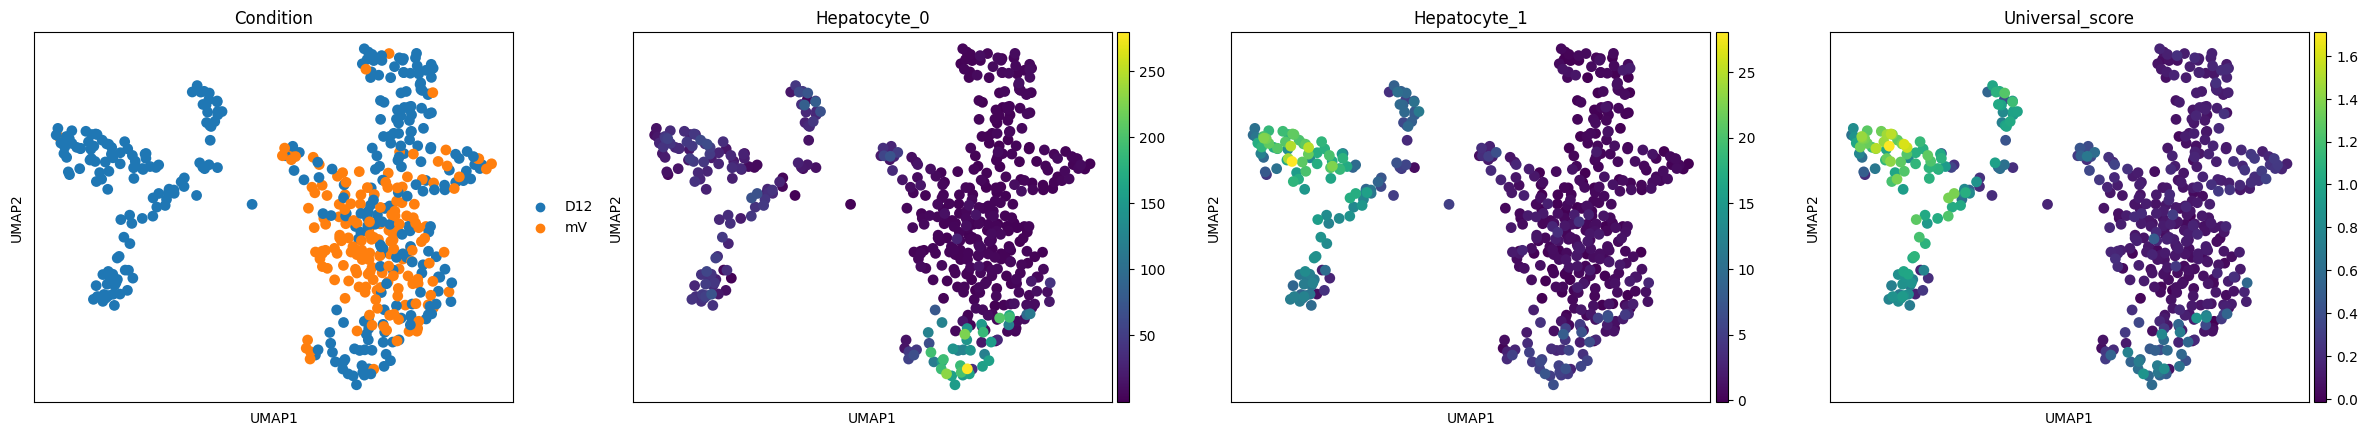

In [18]:
#mV is the control and D12 are the senescent cells
sc.pl.umap(adata, color = ['Condition','Hepatocyte_0', 'Hepatocyte_1', 'Universal_score'])

**Plot of scores and stat test:**

In [19]:
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

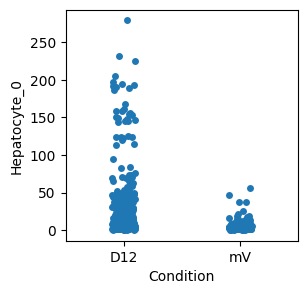

In [20]:
plt.figure(figsize = (3,3))
ax = sns.stripplot(adata.obs, x = 'Condition', y = 'Hepatocyte_0') #probably use violin plot if you have more cells

Default scores from senePy wont be normally distributed in most cases, so we will use a Mann-Whitney

In [21]:
score_var = 'Hepatocyte_0'


a = adata.obs[adata.obs.Condition == 'D12'][score_var]
b = adata.obs[adata.obs.Condition == 'mV'][score_var]
stats.mannwhitneyu(a,b)

MannwhitneyuResult(statistic=42304.0, pvalue=3.49850950860489e-21)

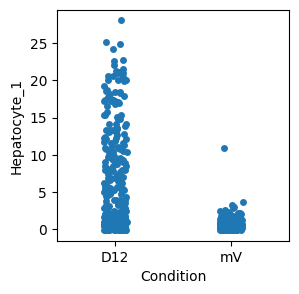

In [22]:
plt.figure(figsize = (3,3))
ax = sns.stripplot(adata.obs, x = 'Condition', y = 'Hepatocyte_1')

In [23]:
score_var = 'Hepatocyte_1'


a = adata.obs[adata.obs.Condition == 'D12'][score_var]
b = adata.obs[adata.obs.Condition == 'mV'][score_var]
stats.mannwhitneyu(a,b)

MannwhitneyuResult(statistic=42275.5, pvalue=4.1805577596924746e-21)

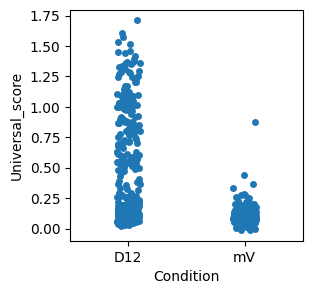

In [24]:
plt.figure(figsize = (3,3))
ax = sns.stripplot(adata.obs, x = 'Condition', y = 'Universal_score')

In [25]:
score_var = 'Universal_score'


a = adata.obs[adata.obs.Condition == 'D12'][score_var]
b = adata.obs[adata.obs.Condition == 'mV'][score_var]
stats.mannwhitneyu(a,b)

MannwhitneyuResult(statistic=45154.0, pvalue=1.1149770619968258e-29)

**Note** that scores across signatures are relative and not directly comparable unless you normalize them to 1